# Final Project
**DATA110: Intro to Machine Learning**  
Brian Roepke  
April 24th, 2021  

# INTRODUCTION

analysis objective and the ML approach applied as well as why you selected it.


Yelp has opened up a large portion of its dataset for academic and personal use. It contains a massive amount of textual data from their reviews and other information about their businesses. I propose to build an NLP model building a sentiment analysis and mapping the polarity to the rating given for the review. Additionally, a machine learning model will predict the highest-rated business by location, the number of reviews, and categories assigned. Finally, I will attempt to use TensorFlow to create a Neural Network. While we only loosely covered this in class, I will try to combine the Machine Learning methods we learned with the tutorials from class to build a classification model off of the text

# EDA/DATA PREP

explore data issues that may require cleansing, data wrangling/munging, etc..  Include visualizations, statistical analysis, etc.. to better understand the data such as how it's distributed and correlations. You must include analysis/text that explains the meaning of each output.

In [1]:
import numpy as np
import pandas as pd
import re
import itertools
import string
import warnings
from timeit import timeit
warnings.filterwarnings('ignore')

from textblob import TextBlob
from textblob import Word

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn import metrics 
from sklearn.model_selection import GridSearchCV, cross_val_score, RepeatedStratifiedKFold
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, MultiLabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_selection import SelectFromModel


# NLTK Imports and Downloads
import nltk
from nltk import word_tokenize
from nltk.sentiment.util import *
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('yelp.csv')

## Data Prep

In [3]:
df.head()

,Unnamed: 0,business_id,name,address,city,state,postal_code,latitude,longitude,stars_x,...,categories,hours,review_id,user_id,stars_y,useful,funny,cool,text,date
0,0,6iYb2HFDywm3zjuRg0shjw,Oskar Blues Taproom,921 Pearl St,Boulder,CO,80302,40.017544,-105.283348,4.0,...,"Gastropubs, Food, Beer Gardens, Restaurants, B...","{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'...",bkHUOCicGZ856vpvcWuW7Q,93z0yh-sUpGZS-cSKu6xxA,5.0,1,0,0,Stopped in on a busy Friday night. Despite the...,2018-03-04 00:59:21
1,1,6iYb2HFDywm3zjuRg0shjw,Oskar Blues Taproom,921 Pearl St,Boulder,CO,80302,40.017544,-105.283348,4.0,...,"Gastropubs, Food, Beer Gardens, Restaurants, B...","{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'...",VKBc48PPwyWIUE1RhBT_8A,Q_CZIvnsDHjpls-EPzzG7Q,2.0,0,0,0,Went there about 1 PM on a Monday. It wasn't ...,2018-08-14 05:22:00
2,2,6iYb2HFDywm3zjuRg0shjw,Oskar Blues Taproom,921 Pearl St,Boulder,CO,80302,40.017544,-105.283348,4.0,...,"Gastropubs, Food, Beer Gardens, Restaurants, B...","{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'...",JKNv1l7JgayZjG6nK__hXQ,rqxTSFFj5fZNmabY1fmTlw,5.0,0,0,0,This was the place the be on Friday Night! If ...,2018-03-17 14:22:48
3,3,6iYb2HFDywm3zjuRg0shjw,Oskar Blues Taproom,921 Pearl St,Boulder,CO,80302,40.017544,-105.283348,4.0,...,"Gastropubs, Food, Beer Gardens, Restaurants, B...","{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'...",WNM_Oyzy6mB6n0Z9lcuZyQ,vNPxlt5f50q0e2nVAScW3Q,4.0,0,0,0,Went to this place with my family over the wee...,2018-04-04 21:16:50
4,4,6iYb2HFDywm3zjuRg0shjw,Oskar Blues Taproom,921 Pearl St,Boulder,CO,80302,40.017544,-105.283348,4.0,...,"Gastropubs, Food, Beer Gardens, Restaurants, B...","{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'...",jG4gZz5FrHyItJXz1YV9Sw,eXRC79iX60xwA1UuGRuWNg,4.0,0,0,0,"Stopped on a midweek afternoon, and so glad th...",2018-04-28 19:17:04


In [4]:
df.shape

(100000, 23)

### Null Values

Nulll values are generally not desireable in a dataset.  In certain cases, observations (rows) with low counts will simply be dropped, in other cases, they can be filled with other values.

In [5]:
# Drop NULL values
df.dropna(inplace=True)

In [6]:
# Drop unwanted columns
df.drop(columns=['Unnamed: 0'], inplace=True)

In [7]:
df['is_open'].value_counts()

1    71554
0    19098
Name: is_open, dtype: int64

In [8]:
# df = df[df['is_open'] == 1].copy()

In [9]:
# Drop is_open column
# df.drop(columns=['is_open'], inplace=True)

In [10]:
# Add column 'text_len' that counts the length for the derived field
df['text_len'] = df.apply(lambda row: len(row['text']), axis = 1)

### Duplicates

A common practice is to review any duplicates.  If there are large quantities, they can skew the results.

In [11]:
len_before = df.shape[0]
df.drop_duplicates(inplace=True)
len_after = df.shape[0]

print("Before =", len_before)
# drop duplicates
print("After =", len_after)
print('')
print("Total Removed =", len_before - len_after)

Before = 90652
After = 90652

Total Removed = 0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90652 entries, 0 to 99999
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   business_id   90652 non-null  object 
 1   name          90652 non-null  object 
 2   address       90652 non-null  object 
 3   city          90652 non-null  object 
 4   state         90652 non-null  object 
 5   postal_code   90652 non-null  object 
 6   latitude      90652 non-null  float64
 7   longitude     90652 non-null  float64
 8   stars_x       90652 non-null  float64
 9   review_count  90652 non-null  int64  
 10  is_open       90652 non-null  int64  
 11  attributes    90652 non-null  object 
 12  categories    90652 non-null  object 
 13  hours         90652 non-null  object 
 14  review_id     90652 non-null  object 
 15  user_id       90652 non-null  object 
 16  stars_y       90652 non-null  float64
 17  useful        90652 non-null  int64  
 18  funny         90652 non-nu

In [13]:
# show counts values of each categorical variable
print (df['city'].value_counts(), '\n')
print (df['state'].value_counts(), '\n')

Austin                15652
Portland              11691
Boston                 9222
Atlanta                8913
Vancouver              6763
                      ...  
BURNABY                   1
Heathrow                  1
Oak Grove                 1
Needham Heights           1
Newton Upper Falls        1
Name: city, Length: 274, dtype: int64 

MA    24117
TX    16203
OR    14174
FL    11246
GA    11221
BC     7280
OH     3748
CO     1387
WA     1273
KS        3
Name: state, dtype: int64 



In [14]:
print(len(df))
df = df[df['state'] != 'KS'].copy()
print(len(df))

90652
90649


**Note:** There are not enough observations for Kansas, these have been dropped.

**Variable Descriptions:**  

1. **business_id:** string, 22 character unique string business id
1. **name:** string, the business's name
1. **address:** string, the full address of the business
1. **city:** string, the city
1. **state:** string, 2 character state code, if applicable
1. **postal code:** string, the postal code
1. **latitude:** float, latitude
1. **longitude:** float, longitude
1. **stars_x:** float, star rating, rounded to half-stars
1. **review_count:** integer, number of reviews
1. **is_open:** integer, 0 or 1 for closed or open, respectively
1. **attributes:** object, business attributes to values. note: some attribute values might be objects
1. **categories:** an array of strings of business categories
1. **hours:** an object of key day to value hours, hours are using a 24hr clock
1. **review_id:** string, 22 character unique string review id
1. **stars_y:** integer, star rating (the data is a float64 here, but only valid numbers were integers 1-5)
1. **useful:** integer, number of useful votes received
1. **funny:** integer, number of funny votes received
1. **cool:** integer, number of cool votes received

In [15]:
# add a column for positive or negative
df['target'] = df['stars_x'].apply(lambda c: 0 if c < 4 else 1)

## EDA

In [16]:
df.describe()

,latitude,longitude,stars_x,review_count,is_open,stars_y,useful,funny,cool,text_len,target
count,90649.000000,90649.000000,90649.000000,90649.000000,90649.000000,90649.000000,90649.000000,90649.000000,90649.000000,90649.000000,90649.000000
mean,38.388287,-92.760983,3.749611,424.967578,0.789319,3.802215,0.958190,0.326953,0.368454,576.716235,0.573090
std,6.996094,19.665105,0.639393,669.496044,0.407794,1.356062,2.103044,1.188864,1.193615,526.057956,0.494632
min,28.136102,-123.259393,1.000000,5.000000,0.000000,1.000000,0.000000,0.000000,0.000000,5.000000,0.000000
25%,30.341274,-122.475356,3.500000,79.000000,1.000000,3.000000,0.000000,0.000000,0.000000,236.000000,0.000000
50%,42.252694,-84.379134,4.000000,214.000000,1.000000,4.000000,0.000000,0.000000,0.000000,416.000000,1.000000
75%,45.362044,-71.226121,4.000000,477.000000,1.000000,5.000000,1.000000,0.000000,0.000000,733.000000,1.000000
max,49.337106,-70.801636,5.000000,4708.000000,1.000000,5.000000,128.000000,39.000000,47.000000,5000.000000,1.000000


In [17]:
df.corr()

,latitude,longitude,stars_x,review_count,is_open,stars_y,useful,funny,cool,text_len,target
latitude,1.000000,-0.370833,-0.036338,-0.122304,-0.066383,-0.011120,0.012506,0.013297,-0.004166,0.002735,-0.047622
longitude,-0.370833,1.000000,-0.089861,-0.033871,0.041396,-0.048018,-0.006208,-0.016600,-0.024574,0.021132,-0.071477
stars_x,-0.036338,-0.089861,1.000000,0.165457,0.143071,0.432100,-0.040790,-0.032776,0.034865,-0.068748,0.809374
review_count,-0.122304,-0.033871,0.165457,1.000000,0.103371,0.074098,-0.059601,-0.010743,-0.005004,-0.011075,0.229836
is_open,-0.066383,0.041396,0.143071,0.103371,1.000000,0.073706,-0.026530,-0.023980,-0.023033,-0.032105,0.145526
stars_y,-0.011120,-0.048018,0.432100,0.074098,0.073706,1.000000,-0.101544,-0.080006,0.060508,-0.171639,0.348259
useful,0.012506,-0.006208,-0.040790,-0.059601,-0.026530,-0.101544,1.000000,0.547143,0.657177,0.291643,-0.032950
funny,0.013297,-0.016600,-0.032776,-0.010743,-0.023980,-0.080006,0.547143,1.000000,0.662080,0.205411,-0.029870
cool,-0.004166,-0.024574,0.034865,-0.005004,-0.023033,0.060508,0.657177,0.662080,1.000000,0.199942,0.023951
text_len,0.002735,0.021132,-0.068748,-0.011075,-0.032105,-0.171639,0.291643,0.205411,0.199942,1.000000,-0.057954


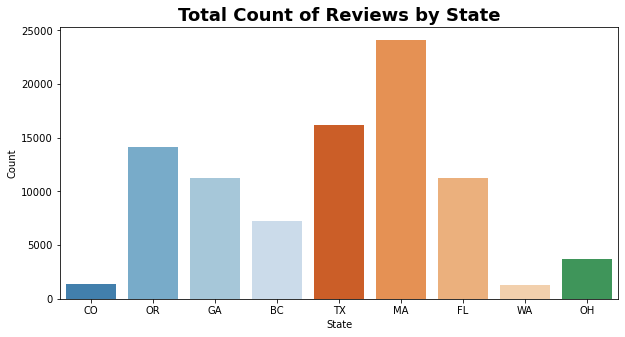

In [18]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='state', palette='tab20c')
plt.title("Total Count of Reviews by State", weight='bold').set_fontsize('18')
plt.xlabel("State")
plt.ylabel("Count");

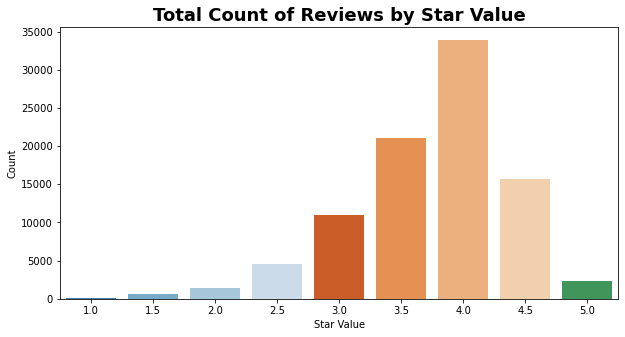

In [19]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, x="stars_x", palette='tab20c')
plt.title("Total Count of Reviews by Star Value", weight='bold').set_fontsize('18')
plt.xlabel("Star Value")
plt.ylabel("Count");

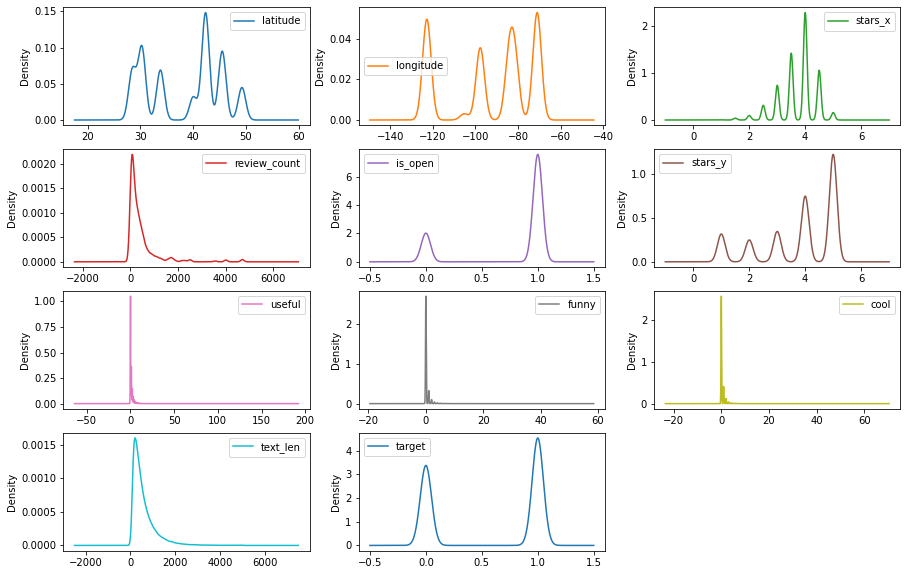

In [20]:
df.plot(figsize=(15,10), kind='density', subplots=True, layout=(4,3), sharex=False);

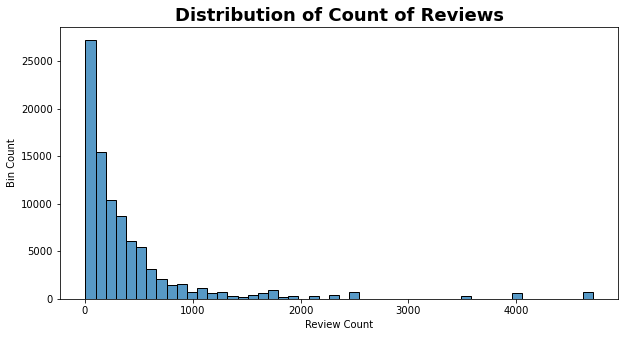

In [21]:
plt.figure(figsize=(10,5))
sns.histplot(x='review_count', data=df, bins=50);
plt.title("Distribution of Count of Reviews", weight='bold').set_fontsize('18')
plt.xlabel("Review Count")
plt.ylabel("Bin Count");

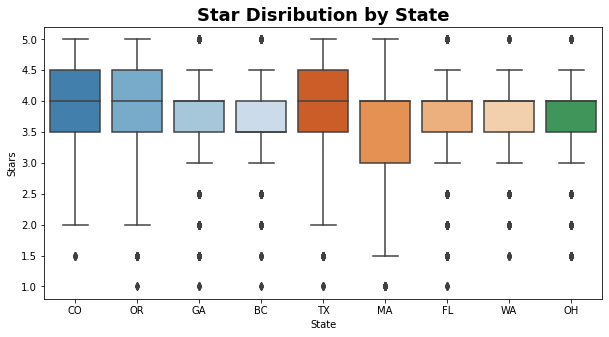

In [22]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df, x='state', y='stars_x', palette="tab20c")
plt.title("Star Disribution by State", weight='bold').set_fontsize('18')
plt.xlabel("State")
plt.ylabel("Stars");

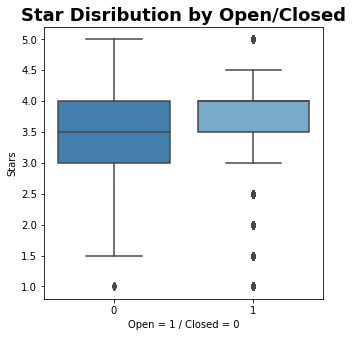

In [23]:
plt.figure(figsize=(5,5))
sns.boxplot(data=df, x='is_open', y='stars_x', palette="tab20c")
plt.title("Star Disribution by Open/Closed", weight='bold').set_fontsize('18')
plt.xlabel("Open = 1 / Closed = 0")
plt.ylabel("Stars");

### Check for Outliers

In [24]:
# Function to print the number of outliers in a column.
def get_outliers(df):
    '''Function to identify the number of outliers +/- 3 standard deviations outside of mean.
    Pass this function a dataframe and it returns a dictionary'''
    
    outs = {}
    
    df = df.select_dtypes(include=['int64'])

    
    for col in df.columns:
        
        # calculate summary statistics
        data_mean, data_std = np.mean(df[col]), np.std(df[col])
        
        # identify outliers
        cut_off = data_std * 3
        lower, upper = data_mean - cut_off, data_mean + cut_off
        
        # identify outliers
        outliers = [x for x in df[col] if x < lower or x > upper]
        
        outs[col] = len(outliers)
        
    return outs

In [25]:
get_outliers(df)

{'review_count': 2195,
 'is_open': 0,
 'useful': 1389,
 'funny': 1615,
 'cool': 1643,
 'text_len': 1781,
 'target': 0}

## Text Cleaning

For **Parts** of our analysis, the text needs to have some basic transformation for our models to work propertly.  These are as follows:

1. **Lower**: Convert all characters to lowercase
1. **Remove Punctuation**: In most cases, punctuation doesn't help NLP and ML models and can be removed.
1. **Stop Word Removal**: Stop words generally don't add context to analysis (unless the length of text is very short (`100` - `200` characters) and can be removed.
1. **Lemmatization**: Words will be reduced to there *Lemma* or root.  This will greatly improve the accuracy of the analysis since words like `simming` and `swimmer` will be reduced to `swim`.

**Note**: The orginal text will be preserved for other analysis.

In [26]:
df['text'][0]

"Stopped in on a busy Friday night. Despite the crowd, the service was expedient and warm. \n\nThe beers here speak for themselves, so we sampled some of their taproom only offerings, and the galaxy smash was clean, tropical and sessionable.\n\nThis being said, the real star of this place is the pizza. It's a hand tossed style crust, that's the perfect mix of crispy and doughy. We ordered the special pizza (luau- bacon, pineapple and fresh jalapeño), and it was the perfect mix of fat, sweetness and heat. \n\nIf you're looking for a comfortable spot to grab a beer, and share some food with some friends on pearl, this is the place!"

In [27]:
def clean_string(text, stem="None"):
    
    final_string = ""
    
    # Make lower
    text = text.lower()
    
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)

    text = text.split()
    useless_words = nltk.corpus.stopwords.words("english") + list(string.punctuation)
    useless_words = useless_words + ['.', ',', '!', "'"]
    
    # Remove stop words
    text_filtered = [word for word in text if not word in useless_words]
    
    # Remove numbers
    text_filtered = [re.sub('\w*\d\w*', '', w) for w in text_filtered]
    
    # Stem or Lemmatize
    if stem == 'Stem':
        stemmer = PorterStemmer() 
        text_stemmed = [stemmer.stem(y) for y in text_filtered]
    elif stem == 'Lem':
        lem = WordNetLemmatizer()
        text_stemmed = [lem.lemmatize(y) for y in text_filtered]
    else:
        text_stemmed = text_filtered
    
    for word in text_stemmed:
        final_string += word + " "
    
    return final_string

In [28]:
df['text_clean'] = df['text'].apply(lambda x: clean_string(x, stem='Lem'))

In [29]:
df['text_clean'][0]

'stopped busy friday night despite crowd service expedient warm beer speak sampled taproom offering galaxy smash clean tropical sessionable said real star place pizza hand tossed style crust thats perfect mix crispy doughy ordered special pizza luau bacon pineapple fresh jalapeño perfect mix fat sweetness heat youre looking comfortable spot grab beer share food friend pearl place '

## Sentiment Analysis

For our sentiment analysis section, we will be using the `TextBlob` package to assist in creating `polarity scores` or sentiment scores that range from `-1` to `1` where lower scores are more negative and higher more positive.  Based off of these scores, we'll add a classifier of `1` for positive and `0` for negative to be used later in our prediction model. 

**Note**: `0` is technically nuetral sentiment, we'll verify how many observations were neutral before assuming we can use a binary label.

In [30]:
def get_sentiment(x):
    '''using TextBlob, get the sentiment score for a given body of text'''
    blob = TextBlob(x)
    return blob.sentiment.polarity

In [31]:
# Apply the Polarity Scoring from TextBlob
df['sentiment'] = df['text'].apply(lambda x: get_sentiment(x))

In [32]:
# Create a few extra columns to aid in the analysis
df['sentiment_label'] = df['sentiment'].apply(lambda x: 1 if x >= 0 else 0)

In [33]:
df[df.columns[-3:]].sample(5, random_state=555)

,text_clean,sentiment,sentiment_label
58515,recently austin business stopped new bra servi...,0.312121,1
21743,love place good indian food happy bring indian...,0.589167,1
22436,alot fun like dj karaoke forget line help alot...,-0.047793,0
68079,really dig fun hut outside think space nice la...,0.193796,1
16921,poorly maintained course perhaps considered ch...,0.045556,1


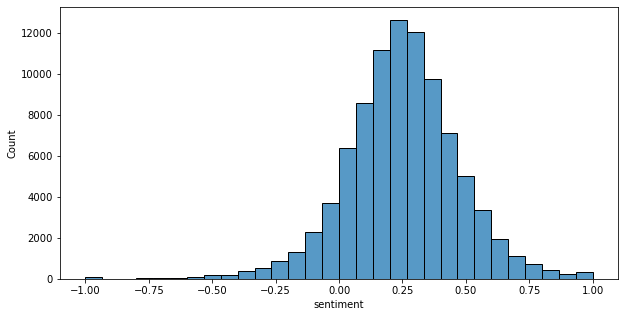

In [34]:
plt.figure(figsize=(10, 5))
sns.histplot(df, x='sentiment', palette="tab20c", bins=30);

**Observations:**

The distributions of sentiment, similar to the `1-5` star reviews is left skewed to the positive.  There are very few that have a `<0` polartity score.

In [35]:
len(df[df['sentiment'] == 0])

575

# FEATURE SELECTION/ MODELING 

determine features to be applied and create a model

In [36]:
targets = ['categories', 'city', 'state', 'postal_code', 'is_open', 'text_len']

In [37]:
catFeat = df[targets].copy()

In [38]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()


catFeat['categories'] = le.fit_transform(catFeat['categories'].astype(str))
catFeat['city'] = le.fit_transform(catFeat['city'].astype(str))
catFeat['state'] = le.fit_transform(catFeat['state'].astype(str))
catFeat['postal_code'] = le.fit_transform(catFeat['postal_code'].astype(str))

catFeat.head()

,categories,city,state,postal_code,is_open,text_len
0,2803,24,1,385,1,630
1,2803,24,1,385,1,885
2,2803,24,1,385,1,174
3,2803,24,1,385,1,553
4,2803,24,1,385,1,841


In [39]:
# Split the data into 30% test and 70% training
X_train, X_test, y_train, y_test = train_test_split(catFeat, 
                                                    df['target'], 
                                                    test_size=0.3, random_state=0)

# Create a random forest classifier for feature importance
clf = RandomForestClassifier(random_state=42, n_jobs=-1)

clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(targets, clf.feature_importances_):
    print(feature)

('categories', 0.48254722812710854)
('city', 0.07622803367225821)
('state', 0.02432493105566927)
('postal_code', 0.24909213550634787)
('is_open', 0.028847310650667084)
('text_len', 0.13896036098794914)


**Notes:**  

Based on the RandomForest test for classifier importance, `categories`, `postal_code`, and `text_len` are the most important features adding up to about `0.835` of the total importance. 

In [40]:
from sklearn.feature_selection import chi2

y = df['target'].values

x = catFeat.values

chi_scores = chi2(x, y)

In [41]:
# supporess scientific notation
pd.set_option('display.float_format', lambda x: '%.10f' % x)

p_values = pd.Series(chi_scores[1], index = catFeat.columns)
p_values.sort_values(ascending = False , inplace = True)
p_values

is_open       0.0000000000
state         0.0000000000
city          0.0000000000
categories    0.0000000000
postal_code   0.0000000000
text_len      0.0000000000
dtype: float64

**Note:**  
For Based on the `p-values < 0.05` there is no dependence between any of the target variables.

## Sentiment Based Prediction Model:

Next, we'll create a Supervised ML model to predict whether a customer will recommend a product based on the text from the review and the sentiment of that text, and the length of the review.

To create our model, we will be mixing both text and numeric values.  There are multiple ways to accomplish this, but we will be using a `ColumnTransformer` in a Pipeline[2].

### Model Selection
During this section, we will use the ColumnTransformer to perform all of the pre-processing steps.  A `FeatureUnion` could also be used but isn't required since we're not transforming the entire numeric data with a PCA process [2].

>*FeatureUnion applies different transformers to the whole of the input data and then combines the results by concatenating them.*  
>*ColumnTransformer, on the other hand, applies different transformers to different subsets of the whole input data, and again concatenates the results.*

In [42]:
X = df[['categories', 'postal_code', 'text', 'sentiment', 'text_len']]
y = df['target']

In [43]:
print(X.shape)
print(y.shape)

(90649, 5)
(90649,)


In [46]:
def create_pipe(clf):
    '''Create a pipeline for a given classifier.  The classifier needs to be an instance
    of the classifier with all parmeters needed specified.'''
    
    # Each pipeline uses the same column transformer.  
    column_trans = ColumnTransformer(
        [('Text', TfidfVectorizer(stop_words='english'), 'text'),
         ('Categories', TfidfVectorizer(stop_words='english'), 'categories'),
         ('postal_code', OneHotEncoder(dtype='int', handle_unknown='ignore'),['postal_code']),
         ('Text Length', MinMaxScaler(), ['text_len']),
         ('Sentiment', MinMaxScaler(), ['sentiment'])],
        remainder='drop') 
    
    pipeline = Pipeline([('prep',column_trans),
                         ('over', SMOTE(random_state=42)),
                         ('under', RandomUnderSampler(random_state=42)),
                         ('clf', clf)])
     
    return pipeline

In [47]:
models = {'ComplementNB' : ComplementNB(),
          #'SVC' : SVC(class_weight='balanced', random_state=42),
          #'RandomForest' : RandomForestClassifier(class_weight='balanced', random_state=42),
          'LogReg' : LogisticRegression(random_state=42, class_weight='balanced', max_iter=500)}

for name, model, in models.items():
    clf = model
    pipeline = create_pipe(clf)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    %time scores = cross_val_score(pipeline, X, y, scoring='f1_macro', cv=cv, n_jobs=-1, error_score='raise')
    print(name, ': Mean f1 Macro: %.3f and Standard Deviation: (%.3f)' % (np.mean(scores), np.std(scores)))

CPU times: user 1.09 s, sys: 1.95 s, total: 3.05 s
Wall time: 7min 51s
ComplementNB : Mean f1 Macro: 0.791 and Standard Deviation: (0.004)
CPU times: user 989 ms, sys: 1.77 s, total: 2.76 s
Wall time: 10min 21s
LogReg : Mean f1 Macro: 0.831 and Standard Deviation: (0.003)


# PERFORMANCE ASSESSMENT

assess model performance using appropriate metrics.

## Model Building

In [48]:
# Make training and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=53)

In [49]:
print(y_train.shape)
print(X_train.shape)

(60734,)
(60734, 5)


In [50]:
def get_params(parameters, X, y, pipeline):
    ''' implements a the GridSearch Cross validation for a given model and set of parameters'''
    
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1)
    grid = GridSearchCV(pipeline, parameters, scoring='f1_macro', n_jobs=-1, cv=cv, error_score='raise')
    grid.fit(X, y)

    return grid

In [51]:
parameters = [{'clf__solver' : ['newton-cg', 'lbfgs', 'sag', 'liblinear'],
               'clf__C' : [10 ,100, 1000]}]

clf = LogisticRegression(random_state=42, max_iter=500)
pipeline = create_pipe(clf)
grid = get_params(parameters, X_train, y_train, pipeline)

print("Best cross-validation accuracy: {:.3f}".format(grid.best_score_))
print("Test set score: {:.3f}".format(grid.score(X_test, y_test))) 
print("Best parameters: {}".format(grid.best_params_))

log_C = grid.best_params_['clf__C']
log_solver = grid.best_params_['clf__solver']

Best cross-validation accuracy: 0.823
Test set score: 0.822
Best parameters: {'clf__C': 10, 'clf__solver': 'lbfgs'}


## Model Evaluation

In [52]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('predicted label')

In [53]:
def fit_and_print(pipeline, name):
    ''' take a supplied pipeline and run it against the train-test spit 
    and product scoring results.'''
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    score = metrics.f1_score(y_test, y_pred, average='macro')

    print(metrics.classification_report(y_test, y_pred, digits=3))

    cm = metrics.confusion_matrix(y_test, y_pred, labels=[0,1])
    plot_confusion_matrix(cm, classes=[0,1])

              precision    recall  f1-score   support

           0      0.789     0.805     0.797     12706
           1      0.854     0.841     0.848     17209

    accuracy                          0.826     29915
   macro avg      0.822     0.823     0.822     29915
weighted avg      0.827     0.826     0.826     29915

Confusion matrix, without normalization


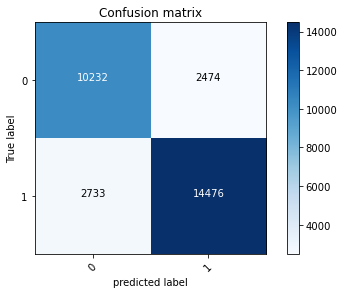

In [54]:
clf = LogisticRegression(C=log_C, solver=log_solver, random_state=42, max_iter=500)
pipeline = create_pipe(clf)
fit_and_print(pipeline, 'Logistic Regression')

**Observations**:

This model performed extremely well across our dataset with an `f1 macro` score of `0.966`.  The dataset has imbalanced, which was corrected for SMOTE (Over Sampling combined with Undersampling).  The result was a very strong predictor model based on `categories`, `city`, `state`, `text`, `sentiment`, `text_len`.

**Synthetic Minority Oversampling Technique** uses a nearest-neighbor approach for generating new minority class samples.  The method is applied only to the training data and then tested on the original, untouched test partition.  The method chosen here is first to oversample the minority class making it balanced, and then undersample it to reduce the size.  This helps bring balance without bloating the dataset [4].

## Model Selection

In [ ]:
df['categories'] = df['categories'].apply(lambda w: re.sub(' ', '', w))
df['categories'] = df['categories'].apply(lambda w: w.split(","))

In [ ]:
df['categories'][0]

In [ ]:
X = df[['text', 'categories']]
y = df['categories']

In [ ]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y)

In [ ]:
print(X.shape)
print(y.shape)
print(mlb.classes_)

In [ ]:
def create_pipe(clf):
    '''Create a pipeline for a given classifier.  The classifier needs to be an instance
    of the classifier with all parmeters needed specified.'''
    
    # Each pipeline uses the same column transformer.  
    column_trans = ColumnTransformer(
        [('text', TfidfVectorizer(stop_words='english'), 'text')],
        remainder='drop') 
    
    pipeline = Pipeline([('prep',column_trans), 
                         ('clf', clf)])
     
    return pipeline

In [ ]:
models = {'RF' : OneVsRestClassifier(RandomForestClassifier(), n_jobs=-1),
          'LogReg' :LogisticRegressioneVsRestClassifier(LogisticRegression(), n_jobs=-1)}

for name, model, in models.items():
    clf = model
    pipeline = create_pipe(clf)
    scores = cross_val_score(pipeline, X, y, scoring='f1_macro', cv=3, n_jobs=-1, error_score='raise')
    print(name, ': Mean f1 Macro: %.3f and Standard Deviation: (%.3f)' % (np.mean(scores), np.std(scores)))

**Notes**:

Again the `SVC` classifier performed the best with `LogisticRegression` coming out second best.   `MultinomialNB` perfrormed the worst out of these.

## Model Building & Validation

In [ ]:
# Make training and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [ ]:
print(y_train.shape)
print(X_train.shape)

In [ ]:
# Note: Optimization was performed prior to Hyperparemeter selection
clf = OneVsRestClassifier(LogisticRegression(class_weight='balanced', random_state=42))
pipeline = create_pipe(clf)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
score = metrics.f1_score(y_test, y_pred, average='macro')

print(metrics.classification_report(y_test, y_pred, digits=3))

**Observations**:

 - There are very few observations in the `5` class overall in the dataset.  You can see in the support column for this class only `38` samples are present.  Through synthetic oversampling (SMOTE), we could get a small precision and recall score, but it's difficult without more observations.
 - The `2` and `3` classes are also smaller and therefore do not have as high an `f1` score.
 - The remainder of the classes are all performing very well.  
 - The `f1 macro` score is `~.6`, which normally is not considered a good score, but in the case of multi-value classification, it doesn't necessarily mean it's a poor-performing model.  We can test this thorough inspection of the actual predictions.

In [ ]:
# Retreive the text lables from the MultiLabelBinarizer
pred_labels = mlb.inverse_transform(y_pred)

# Append them to the DataFrame
X_test['Predicted Labels'] = pred_labels

In [ ]:
# Display a random sample of them
pd.set_option('display.max_colwidth', -1)
X_test.sample(10, random_state=60)

# CONCLUSION 

a conclusion summarizing the analysis and the results. Were you able to meet your analysis objective as described in your introduction?

# REFERENCES

1. [Yelp Reviews Dataset](https://www.yelp.com/dataset)